## **Reinforcement Learning**

### 라이브러리 호출

In [1]:
! pip install gym

In [33]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v1').unwrapped
plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### DQN 리플레이 메모리

In [34]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
  def __init__(self, capacity):
    self.capacity = capacity
    self.memory = []
    self.position = 0

  def push(self, *args):
    if len(self.memory) < self.capacity:
      self.memory.append(None)
    self.memory[self.position] = Transition(*args)
    self.position = (self.position + 1) % self.capacity

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)

### DQN 모델 네트워크

In [35]:
class DQN(nn.Module):
  def __init__(self, h, w, outputs):
    super(DQN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
    self.bn1 = nn.BatchNorm2d(16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
    self.bn3 = nn.BatchNorm2d(32)

    def con2d_size_out(size,kernel_size=5, stride=2):
      return (size - (kernel_size - 1) - 1) // stride + 1

    convw  = con2d_size_out(con2d_size_out(con2d_size_out(w)))
    convh  = con2d_size_out(con2d_size_out(con2d_size_out(h)))
    linear_input_size = convw * convh *32
    self.head = nn.Linear(linear_input_size, outputs)

  def forward(self, x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.relu(self.bn3(self.conv3(x)))
    return self.head(x.view(x.size(0), -1))

### 이미지 추출 및 처리

In [5]:
! pip install pyglet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.1/962.1 kB 11.5 MB/s eta 0:00:00


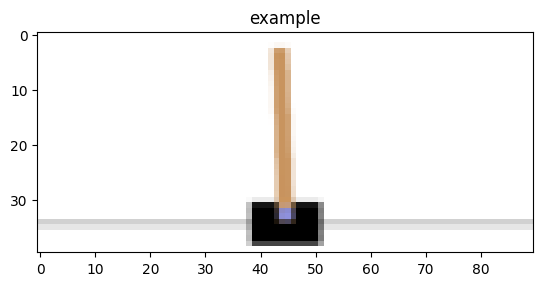

In [36]:
import pyglet

resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.Resampling.BICUBIC),
                    T.ToTensor()])

def get_cart_location(screen_width):
  world_width = env.x_threshold*2
  scale = screen_width / world_width
  return int(env.state[0]*scale+screen_width/2.0)

def get_screen():
  screen = env.render(mode='rgb_array').transpose((2, 0, 1))
  _, screen_height, screen_width = screen.shape
  screen = screen[:, int(screen_height*0.4):int(screen_height*0.8)]
  view_width = int(screen_width*0.6)
  cart_location = get_cart_location(screen_width)

  if cart_location < view_width // 2:
    slice_range = slice(view_width)
  elif cart_location > (screen_width - view_width // 2):
    slice_range = slice(-view_width, None)
  else:
    slice_range = slice(cart_location - view_width //2,
                        cart_location + view_width //2)

  screen = screen[:,:,slice_range]
  screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
  screen = torch.from_numpy(screen)
  return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('example')
plt.show()

### 모델 객체화 및 손실 함수 정의

In [37]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
  global steps_done
  sample = random.random()
  eps_threshold = EPS_END + (EPS_START - EPS_END) * \
    math.exp(-1. * steps_done / EPS_DECAY)
  steps_done += 1
  if sample > eps_threshold:
    with torch.no_grad():
      return policy_net(state).max(1)[1].view(1, 1)
  else:
    return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episode_durations = []

### 모델에서 사용할 옵티마이저 정의

In [38]:
def optimize_model():
  if len(memory) < BATCH_SIZE:
    return

  transitions = memory.sample(BATCH_SIZE)
  batch = Transition(*zip(*transitions))
  non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
  non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

  state_batch = torch.cat(batch.state)
  action_batch = torch.cat(batch.action)
  reward_batch = torch.cat(batch.reward)

  state_action_values = policy_net(state_batch).gather(1, action_batch)
  next_state_values = torch.zeros(BATCH_SIZE, device=device)
  next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
  expected_state_action_values = (next_state_values*GAMMA) + reward_batch
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
  optimizer.zero_grad()
  loss.backward()

  for param in policy_net.parameters():
    param.grad.data.clamp_(-1, 1)
  optimizer.step()

### 모델 학습

In [39]:
num_episodes = 50

for i_episode in range(num_episodes):
  env.reset()
  last_screen = get_screen()
  current_screen = get_screen()
  state = current_screen - last_screen

  for t in count():
    action = select_action(state)
    _, reward, terminated, truncated, _ = env.step(action.item())
    done = terminated or truncated
    reward = torch.tensor([reward], device=device)

    last_screen = current_screen
    current_screen = get_screen()

    if not done:
      next_state = current_screen - last_screen
    else:
      next_state = None

    memory.push(state, action, next_state, reward)
    state = next_state

    optimize_model()
    if done:
      episode_durations.append(t + 1)
      break

  if i_episode % TARGET_UPDATE==0:
    target_net.load_state_dict(policy_net.state_dict())

print('terminate')
#env.render()
env.close()
plt.show()

terminate
